# PBS dataset analysis

This notebook aims to assess our model's performances on the dataset PBS. It is applied to the cingulate region.

In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.svm import LinearSVC

from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"

In [3]:
model_dir = '/neurospin/dico/lguillon/distmap/PBS/runs/right/checkpoint.pt'
model = VAE((1, 80, 88, 104), 75, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

### Loading of HCP test set

In [4]:
subject_dir = "/neurospin/dico/lguillon/distmap/PBS/data/"
data_dir = "/neurospin/dico/lguillon/distmap/PBS/data/"
test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))
distmaps = np.load(os.path.join(data_dir, "Rtest_distmap.npy"),
                   mmap_mode='r')
filenames = np.load(os.path.join(data_dir, "Rtest_sub_id.npy"))
print(distmaps.shape, filenames.shape)

subset = SkeletonDataset(dataframe=distmaps,
                         filenames=filenames,
                         data_transforms=False)
testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

(200, 78, 86, 99, 1) (200,)


### Loading of PBS cohort data

In [5]:
data_dir = "/neurospin/dico/data/deep_folding/current/datasets/epilepsy/crops/1mm"
data_path = "SC_precentral/no_mask"

In [7]:
print(os.path.join(data_dir, "controls", data_path, "Rdistmap.npy"))

/neurospin/dico/data/deep_folding/current/datasets/epilepsy/crops/1mm/controls/SC_precentral/no_mask/Rdistmap.npy


In [6]:
pbs_data = pd.read_csv('/neurospin/dico/lguillon/distmap/PBS/data/pbs_cohort.csv')

In [386]:
pbs_neg_handedness = pd.DataFrame()
pbs_handedness = pbs_data[['subject', 'group', 'IRM.1', 'handedness', 'lesion_side']]
# pbs_neg_handedness = pbs_handedness[(pbs_handedness['IRM.1']=='negative') & (pbs_handedness['group']=='patients')]
# pbs_pos_handedness = pbs_handedness[pbs_handedness['IRM.1']=='positive'].reset_index(drop=True)

In [8]:
# pbs_neg_handedness['subject'] = [pbs_neg_handedness['subject'][k] for k in pbs_neg_handedness.index]

In [116]:
# pbs_neg_handedness = pbs_neg_handedness[pbs_neg_handedness['handedness']=='D'].drop(columns=('group'))
# pbs_pos_handedness = pbs_pos_handedness[pbs_pos_handedness['handedness']=='D'].drop(columns=('group'))

In [9]:
controls = np.load(os.path.join(data_dir, "controls", data_path, "Rdistmap.npy"),
                   mmap_mode='r')
filenames_controls = np.load(os.path.join(data_dir, "controls", data_path, "sub_id.npy"))

subset_controls = SkeletonDataset(dataframe=controls,
                                 filenames=filenames_controls,
                                 data_transforms=False)
loader_controls = torch.utils.data.DataLoader(
               subset_controls,
               batch_size=1,
               num_workers=1,
               shuffle=False)

pbs_sub_neg = np.load(os.path.join(data_dir, "irm_negatives_centrales", data_path, "Rdistmap.npy"),
                   mmap_mode='r')
filenames_pbs_sub_neg = np.load(os.path.join(data_dir, "irm_negatives_centrales", data_path, "sub_id.npy"))

subset_pbs_sub_neg = SkeletonDataset(dataframe=pbs_sub_neg,
                             filenames=filenames_pbs_sub_neg,
                             data_transforms=False)
loader_pbs_sub_neg = torch.utils.data.DataLoader(
                       subset_pbs_sub_neg,
                       batch_size=1,
                       num_workers=1,
                       shuffle=False)

pbs_sub_pos = np.load(os.path.join(data_dir, "irm_positives_centrales", data_path, "Rdistmap.npy"),
                   mmap_mode='r')
filenames_pbs_sub_pos = np.load(os.path.join(data_dir, "irm_positives_centrales", data_path, "sub_id.npy"))

subset_pbs_sub_pos = SkeletonDataset(dataframe=pbs_sub_pos,
                             filenames=filenames_pbs_sub_pos,
                             data_transforms=False)
loader_pbs_sub_pos = torch.utils.data.DataLoader(
                       subset_pbs_sub_pos,
                       batch_size=1,
                       num_workers=1,
                       shuffle=False)

In [10]:
dico_set_loaders = {'hcp_test': testloader, 
                    'controls': loader_controls, 
                    'pbs_sub_neg': loader_pbs_sub_neg,
                    'pbs_sub_pos': loader_pbs_sub_pos}

root_dir = '/neurospin/dico/lguillon/distmap/PBS/results/'

criterion = nn.MSELoss(reduction='sum')
tester_deletion = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_deletion = tester_deletion.test()
encoded_deletion = {loader_name:[results_deletion[loader_name][k][1] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_deletion = {loader_name:[int(results_deletion[loader_name][k][0].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_deletion = {loader_name:[int(results_deletion[loader_name][k][2].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_deletion = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
var_deletion = {loader_name:[results_deletion[loader_name][k][4] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

hcp_test
[0.0000000e+00 2.8610229e-06 5.2452087e-06 ... 9.9935913e-01 9.9955142e-01
 9.9988782e-01]
[0.0000000e+00 9.2983246e-06 1.0251999e-05 ... 9.9965823e-01 9.9975324e-01
 9.9990916e-01]
[0.0000000e+00 1.7642975e-05 2.4557114e-05 ... 9.9978638e-01 9.9981844e-01
 9.9998927e-01]
[0.0000000e+00 2.3841858e-05 2.6464462e-05 ... 9.9871826e-01 9.9910271e-01
 9.9964750e-01]
[0.0000000e+00 2.0742416e-05 2.4557114e-05 ... 9.9956739e-01 9.9971688e-01
 9.9996638e-01]
[0.0000000e+00 4.0531158e-06 6.4373016e-06 ... 9.9903870e-01 9.9962616e-01
 9.9966884e-01]
[0.00000000e+00 1.01327896e-04 1.15871429e-04 ... 9.99765038e-01
 9.99781013e-01 9.99851823e-01]
[0.0000000e+00 2.6226044e-06 2.8610229e-06 ... 9.9955142e-01 9.9966359e-01
 9.9985051e-01]
[0.0000000e+00 1.3113022e-05 1.7404556e-05 ... 9.9941719e-01 9.9955666e-01
 9.9983978e-01]
[0.0000000e+00 1.3113022e-05 1.9073486e-05 ... 9.9977577e-01 9.9984956e-01
 9.9996257e-01]
[0.0000000e+00 2.8133392e-05 2.8371811e-05 ... 9.9944460e-01 9.9955511e-01


[0.0000000e+00 2.5987625e-05 2.6941299e-05 ... 9.9959946e-01 9.9969554e-01
 9.9982381e-01]
[0.0000000e+00 4.7922134e-05 5.1498413e-05 ... 9.9945533e-01 9.9982917e-01
 9.9998391e-01]
[0.0000000e+00 5.0067902e-06 5.4836273e-06 ... 9.9970090e-01 9.9971163e-01
 9.9980247e-01]
[0.0000000e+00 5.9604645e-06 6.1988831e-06 ... 9.9964750e-01 9.9981844e-01
 9.9989319e-01]
[0.0000000e+00 5.8889389e-05 7.9631805e-05 ... 9.9933863e-01 9.9944985e-01
 9.9967957e-01]
[0.0000000e+00 2.3841858e-06 2.6226044e-06 ... 9.9954069e-01 9.9977160e-01
 9.9980772e-01]
[0.0000000e+00 7.4863434e-05 7.9393387e-05 ... 9.9988782e-01 9.9996793e-01
 9.9998927e-01]
[0.0000000e+00 2.1934509e-05 2.4557114e-05 ... 9.9950862e-01 9.9969029e-01
 9.9995029e-01]
[0.0000000e+00 1.4305115e-06 1.9073486e-06 ... 9.9949265e-01 9.9967957e-01
 9.9984515e-01]
[0.0000000e+00 2.6464462e-05 2.8133392e-05 ... 9.9985051e-01 9.9991453e-01
 9.9999464e-01]
[0.0000000e+00 2.6941299e-05 3.0040741e-05 ... 9.9957812e-01 9.9965823e-01
 9.9969029e-01]

[0.0000000e+00 2.3365021e-05 3.0994415e-05 ... 9.9978638e-01 9.9988782e-01
 9.9989319e-01]
[0.000000e+00 9.536743e-06 1.001358e-05 ... 9.994339e-01 9.997330e-01
 9.998025e-01]
[0.0000000e+00 2.6226044e-06 3.5762787e-06 ... 9.9959946e-01 9.9986112e-01
 9.9987185e-01]
[0.0000000e+00 3.1232834e-05 3.1471252e-05 ... 9.9889672e-01 9.9986112e-01
 9.9992526e-01]
[0.0000000e+00 3.1709671e-05 3.2424927e-05 ... 9.9982381e-01 9.9983442e-01
 9.9998415e-01]
[0.0000000e+00 1.2874603e-05 1.7166138e-05 ... 9.9952567e-01 9.9968493e-01
 9.9981844e-01]
[0.0000000e+00 8.3446503e-06 1.1205673e-05 ... 9.9963152e-01 9.9964750e-01
 9.9968493e-01]
[0.0000000e+00 5.7220459e-06 6.6757202e-06 ... 9.9948204e-01 9.9953532e-01
 9.9960887e-01]
[0.0000000e+00 9.5367432e-06 1.0728836e-05 ... 9.9973297e-01 9.9973822e-01
 9.9982917e-01]
[0.0000000e+00 1.2397766e-05 1.5258789e-05 ... 9.9944985e-01 9.9962616e-01
 9.9982917e-01]
[0.0000000e+00 3.3378601e-06 4.2915344e-06 ... 9.9969554e-01 9.9983442e-01
 9.9996257e-01]
[0.00

In [19]:
df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded_deletion['hcp_test'] +encoded_deletion['controls']+ encoded_deletion['pbs_sub_neg'] + encoded_deletion['pbs_sub_pos']
df_encoded['loss'] = losses_deletion['hcp_test'] + losses_deletion['controls'] + losses_deletion['pbs_sub_neg'] + losses_deletion['pbs_sub_pos']
df_encoded['recon'] = recon_deletion['hcp_test'] + recon_deletion['controls'] +recon_deletion['pbs_sub_neg'] +recon_deletion['pbs_sub_pos']
df_encoded['input'] = input_deletion['hcp_test'] + input_deletion['controls'] + input_deletion['pbs_sub_neg'] + input_deletion['pbs_sub_pos']
df_encoded['var'] = var_deletion['hcp_test'] + var_deletion['controls'] + var_deletion['pbs_sub_neg'] + var_deletion['pbs_sub_pos']
df_encoded['sub'] = list(filenames) + list(filenames_controls) + list(filenames_pbs_sub_neg) + list(filenames_pbs_sub_pos) 
df_encoded['group'] = ['hcp_test' for k in range(len(list(filenames)))] + ['controls' for k in range(len(list(filenames_controls)))] + ['pbs_sub_neg' for k in range(len(list(filenames_pbs_sub_neg)))] + ['pbs_sub_pos' for k in range(len(list(filenames_pbs_sub_pos)))] 

### Selection of right-handed patients only

In [20]:
for k in range(len(df_encoded)):
    if df_encoded['group'][k]=='pbs_sub_neg':
        df_encoded['sub'][k] = "n" + df_encoded['sub'][k]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
df_encoded['handedness'] = ['' for k in range(len(df_encoded))]
for k in range(len(df_encoded)):
    if df_encoded['group'][k]=='hcp_test':
        df_encoded['handedness'][k] = 'D'
    else :
        sub = df_encoded['sub'][k]
        df_encoded['handedness'][k] = pbs_handedness[pbs_handedness['subject']==sub]['handedness'].values[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [22]:
df_encoded_rightH = df_encoded[df_encoded['handedness']=='D']

In [501]:
df_latent = pd.DataFrame()
df_var = pd.DataFrame()
for k in range(75):
    latent_k = []
    var_k = []
    for i in range(len(df_encoded_rightH)):
        latent_k.append(df_encoded_rightH['latent'][i][k])
        var_k.append(df_encoded_rightH['var'][i][k])
    df_latent[str(k)] = latent_k 
    df_var[str(k)] = var_k 

In [504]:
df_encoded_rightH.to_csv('/neurospin/dico/lguillon/distmap/PBS/results/df_encoded_rightH.csv')
df_latent.to_csv('/neurospin/dico/lguillon/distmap/PBS/results/df_latent.csv')
df_var.to_csv('/neurospin/dico/lguillon/distmap/PBS/results/df_var.csv')

In [28]:
deletion_hcp = df_encoded_rightH[df_encoded_rightH['group']=='hcp_test'].reset_index(drop=True)
deletion_controls = df_encoded_rightH[df_encoded_rightH['group']=='controls'].reset_index(drop=True)
deletion_pbs_sub_neg = df_encoded_rightH[df_encoded_rightH['group']=='pbs_sub_neg'].reset_index(drop=True)
deletion_pbs_sub_pos = df_encoded_rightH[df_encoded_rightH['group']=='pbs_sub_pos'].reset_index(drop=True)

### L_{D} metric computation

In [17]:
data_dir = '/neurospin/dico/lguillon/distmap/PBS/data/'
filenames_all = np.load(os.path.join(data_dir,
                                "Rtrain_sub_id.npy"))
distmaps = np.load(os.path.join(data_dir,
                                "Rtrain_distmap.npy"),
                       mmap_mode='r')

subset_sc = SkeletonDataset(dataframe=distmaps, filenames=filenames_all, data_transforms=False)
sc_loader = torch.utils.data.DataLoader(
                          subset_sc,
                          batch_size=8,
                          num_workers=8,
                          shuffle=False)

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders={'hcp_train': sc_loader},
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp_all = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
losses_hcp_all = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
recon_hcp_all = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
input_hcp_all = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}
var_hcp_all = {loader_name:[results_hcp[loader_name][k][4] for k in results_hcp[loader_name].keys()] for loader_name in {'hcp_train': sc_loader}.keys()}

df_encoded_hcp_all = pd.DataFrame()
df_encoded_hcp_all['latent'] = encoded_hcp_all['hcp_train']
df_encoded_hcp_all['loss'] = losses_hcp_all['hcp_train']
df_encoded_hcp_all['recon'] = recon_hcp_all['hcp_train']
df_encoded_hcp_all['input'] = input_hcp_all['hcp_train']
df_encoded_hcp_all['var'] = var_hcp_all['hcp_train']
df_encoded_hcp_all['Group'] = ['hcp_train' for k in range(len(filenames_all))] 
df_encoded_hcp_all['sub'] = list(filenames_all)

hcp_train
[0.0000000e+00 5.0067902e-06 5.4836273e-06 ... 9.9988246e-01 9.9993062e-01
 9.9996793e-01]
[0.0000000e+00 2.6226044e-06 2.8610229e-06 ... 9.9996793e-01 9.9997199e-01
 9.9998391e-01]
[0.0000000e+00 4.7683716e-06 5.4836273e-06 ... 9.9989319e-01 9.9990916e-01
 9.9993587e-01]
[0.0000000e+00 1.1920929e-06 1.6689301e-06 ... 9.9993062e-01 9.9998927e-01
 9.9999464e-01]
[0.0000000e+00 5.2452087e-06 7.3909760e-06 ... 9.9993587e-01 9.9995720e-01
 9.9997866e-01]
[0.0000000e+00 3.0994415e-06 3.5762787e-06 ... 9.9994659e-01 9.9996257e-01
 9.9999464e-01]
[0.0000000e+00 1.4305115e-06 1.9073486e-06 ... 9.9992526e-01 9.9994123e-01
 9.9994659e-01]
[0.0000000e+00 1.1920929e-06 1.9073486e-06 ... 9.9999464e-01 9.9999583e-01
 9.9999785e-01]
[0.0000000e+00 4.7683716e-06 5.4836273e-06 ... 9.9992526e-01 9.9993587e-01
 9.9996793e-01]
[0.0000000e+00 7.1525574e-07 1.1920929e-06 ... 9.9996793e-01 9.9997866e-01
 9.9998927e-01]
[0.0000000e+00 4.2915344e-06 5.2452087e-06 ... 9.9995720e-01 9.9996793e-01
 9.99

[0.0000000e+00 6.1988831e-06 8.5830688e-06 ... 9.9981844e-01 9.9988401e-01
 9.9993587e-01]
[0.0000000e+00 1.6689301e-06 2.1457672e-06 ... 9.9997866e-01 9.9998391e-01
 9.9998927e-01]
[0.0000000e+00 2.3841858e-06 3.3378601e-06 ... 9.9997866e-01 9.9998558e-01
 9.9999464e-01]
[0.0000000e+00 2.3841858e-06 3.5762787e-06 ... 9.9996853e-01 9.9997330e-01
 9.9998391e-01]
[0.0000000e+00 2.3841858e-06 3.0994415e-06 ... 9.9995196e-01 9.9997330e-01
 9.9998927e-01]
[0.0000000e+00 4.2915344e-06 4.7683716e-06 ... 9.9996662e-01 9.9998391e-01
 9.9999940e-01]
[0.0000000e+00 6.1988831e-06 6.6757202e-06 ... 9.9996793e-01 9.9997354e-01
 9.9997866e-01]
[0.0000000e+00 1.6689301e-06 1.9073486e-06 ... 9.9994123e-01 9.9995685e-01
 9.9997509e-01]
[0.0000000e+00 3.0994415e-06 3.3378601e-06 ... 9.9995720e-01 9.9997580e-01
 9.9998927e-01]
[0.0000000e+00 2.3841858e-06 2.8610229e-06 ... 9.9996257e-01 9.9996793e-01
 9.9997866e-01]
[0.000000e+00 8.106232e-06 1.001358e-05 ... 9.997864e-01 9.998131e-01
 9.998665e-01]


In [18]:
def dev(latent_sub, var_sub):
    """
    """
    n = len(latent_sub)
    mean_ctrl = [np.mean([encoded_hcp_all['hcp_train'][k][i] for k in range(801)]) for i in range(n)]
    var_ctrl =  [np.var([encoded_hcp_all['hcp_train'][k][i] for k in range(801)]) for i in range(75)]
    deviations = []
    
    for k in range(n):
        deviations.append(abs(latent_sub[k] - mean_ctrl[k])/np.sqrt(var_ctrl[k]+var_sub[k]))
    return(np.mean(deviations))

In [29]:
dev_test = [dev(deletion_hcp['latent'][k], deletion_hcp['var'][k]) for k in range(len(deletion_hcp))]
dev_controls = [dev(deletion_controls['latent'][k], deletion_controls['var'][k]) for k in range(len(deletion_controls))]
dev_pbs_neg = [dev(deletion_pbs_sub_neg['latent'][k], deletion_pbs_sub_neg['var'][k]) for k in range(len(deletion_pbs_sub_neg))]
dev_pbs_pos = [dev(deletion_pbs_sub_pos['latent'][k], deletion_pbs_sub_pos['var'][k]) for k in range(len(deletion_pbs_sub_pos))]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2668e35dd8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2668e35940>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2668e35fd0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f27431cccc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f27431cc1d0>,
 'means': []}

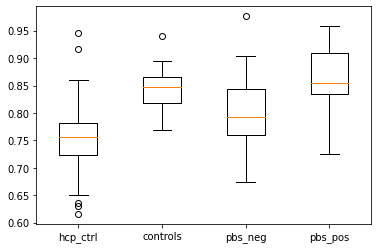

In [30]:
plt.boxplot((dev_test, dev_controls, dev_pbs_neg, dev_pbs_pos),
            labels=('hcp_ctrl','controls', 'pbs_neg', 'pbs_pos'))

In [31]:
F,p_hcp_ctrl = mannwhitneyu(dev_test, dev_controls)
print(p_hcp_ctrl)
F,p_hcp_pbs_neg = mannwhitneyu(dev_test, dev_pbs_neg)
print(p_hcp_pbs_neg)
F,p_hcp_pbs_pos = mannwhitneyu(dev_test, dev_pbs_pos)
print(p_hcp_pbs_pos)
F,p_ctrl_pbs_neg = mannwhitneyu(dev_controls, dev_pbs_neg)
print(p_ctrl_pbs_neg)
F,p_ctrl_pbs_pos = mannwhitneyu(dev_controls, dev_pbs_pos)
print(p_ctrl_pbs_pos)

3.760882626673899e-10
0.012997556332916022
8.532261902850389e-08
0.042389804471122436
0.16297266774383035


In [32]:
pvalues = np.array([p_hcp_ctrl, p_hcp_pbs_neg, p_hcp_pbs_pos,
                    p_ctrl_pbs_neg, p_ctrl_pbs_pos])
multipletests(pvalues, method='bonferroni')

(array([ True, False,  True, False, False]),
 array([1.88044131e-09, 6.49877817e-02, 4.26613095e-07, 2.11949022e-01,
        8.14863339e-01]),
 0.010206218313011495,
 0.01)

### Latent space analysis - all data

In [466]:
X_all = np.array(list(deletion_hcp['latent']) + 
                 list(deletion_controls['latent']) + 
                 list(deletion_pbs_sub_neg['latent']) + 
                 list(deletion_pbs_sub_pos['latent']))
labels = np.array(['hcp_test' for k in range(200)] + 
                  ['controls' for k in range(len(deletion_controls))] + 
                  ['pbs_sub_neg' for k in range(len(deletion_pbs_sub_neg))] +
                  ['pbs_sub_pos' for k in range(len(deletion_pbs_sub_pos))])

In [428]:
pbs_handedness_right = pbs_handedness[pbs_handedness.handedness=='D']

In [429]:
pbs_handedness_right

,subject,group,IRM.1,handedness,lesion_side
0,nsujet01,patients,negative,D,D
1,nsujet08,patients,negative,D,D
2,nsujet10,patients,negative,D,D
3,nsujet12,patients,negative,D,D
4,nsujet20,patients,negative,D,D
5,nsujet22,patients,negative,D,D
6,nsujet23,patients,negative,D,D
7,sujet02,patients,positive,D,D
8,sujet04,patients,positive,D,D
10,sujet06,patients,positive,D,D


In [406]:
df_encoded_rightH['sub'][0]

932554

In [415]:
pbs_data[pbs_data['subject']=='nsujet01'].lesion_side.values[0]

'D'

In [430]:
lesion_side = []
for k in range(len(df_encoded_rightH)):
    if df_encoded_rightH['group'][k]!='hcp_test':
        sub = df_encoded_rightH['sub'][k]
        lesion_side.append(pbs_handedness_right[pbs_handedness_right['subject']==sub].lesion_side.values[0])
    else:
        sub = df_encoded_rightH['sub'][k]
        lesion_side.append('')

In [467]:
reducer = umap.UMAP(n_neighbors=35, random_state=15)
embedding = reducer.fit_transform(X_all)

In [392]:
df_encoded_rightH[['sub','group']].loc[0]['group']

'hcp_test'

In [433]:
np.unique(np.array(lesion_side), return_counts=True)

(array(['', 'D', 'G', 'no'], dtype='<U2'), array([200,  15,  14,  19]))

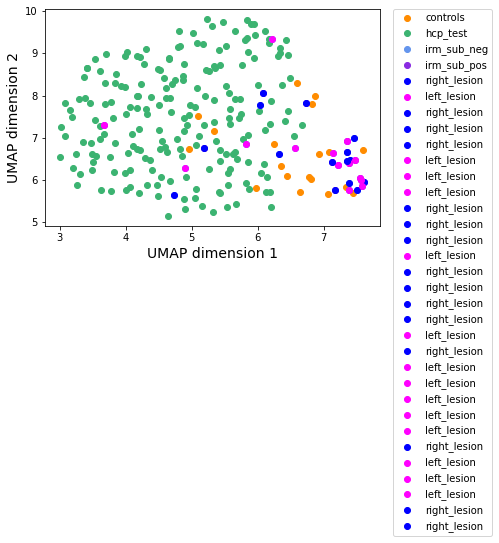

In [445]:
arr = embedding
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'pbs_sub_neg':'cornflowerblue','pbs_sub_pos':'blueviolet'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='pbs_sub_pos':
        g_lab= f"irm_sub_pos"
    elif g=='pbs_sub_neg':
        g_lab = 'irm_sub_neg'
    else:
        g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=1)



# for i, txt in enumerate(list(df_encoded_rightH['sub'])):
#     if df_encoded_rightH[['sub','group']].loc[i]['group']=='pbs_sub_neg' or df_encoded_rightH[['sub','group']].loc[i]['group']=='pbs_sub_pos':
#         ax.annotate(txt, (embedding[i][0], embedding[i][1]))
        
for i, txt in enumerate(lesion_side):
    if txt=='D':
        ax.scatter(embedding[i][0], embedding[i][1], color='blue', label='right_lesion')
    if txt=='G':
        ax.scatter(embedding[i][0], embedding[i][1], color='magenta', label='left_lesion')

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)   

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

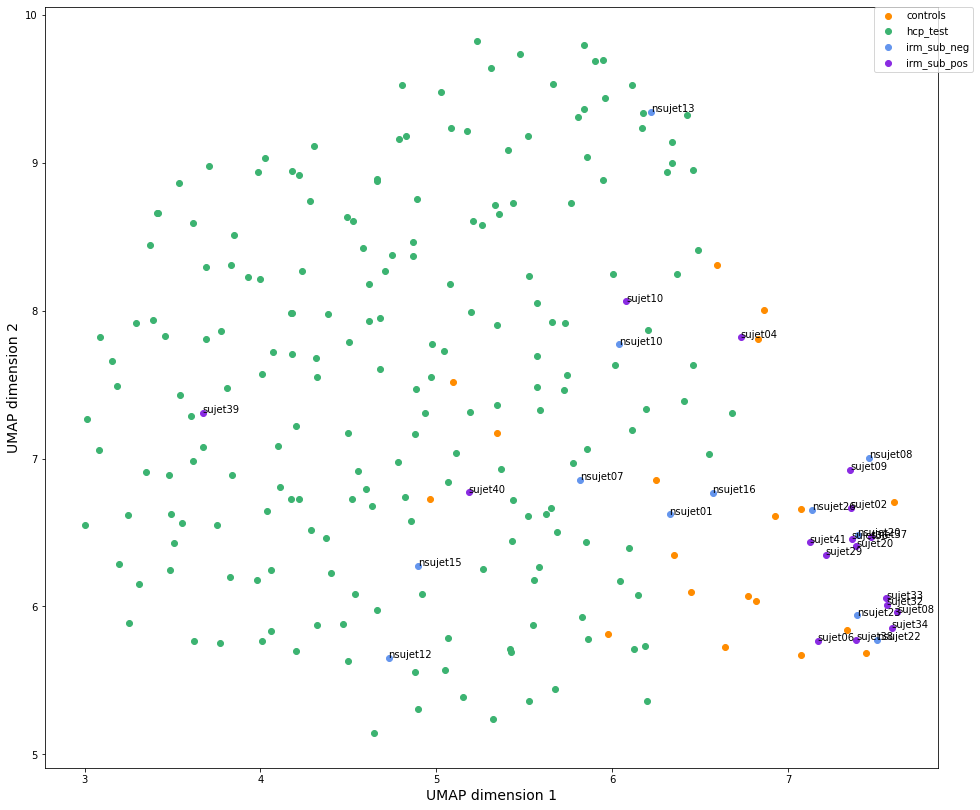

In [469]:
arr = embedding
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'pbs_sub_neg':'cornflowerblue','pbs_sub_pos':'blueviolet'}

fig = plt.figure(figsize=(16,14))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='pbs_sub_pos':
        g_lab= f"irm_sub_pos"
    elif g=='pbs_sub_neg':
        g_lab = 'irm_sub_neg'
    else:
        g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=1)


for i, txt in enumerate(list(df_encoded_rightH['sub'])):
    if df_encoded_rightH[['sub','group']].loc[i]['group']=='pbs_sub_neg' or df_encoded_rightH[['sub','group']].loc[i]['group']=='pbs_sub_pos':
        ax.annotate(txt, (embedding[i][0], embedding[i][1]))

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)   

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [397]:
X_all.shape

(248, 75)

In [399]:
np.unique(labels, return_counts=True)

(array(['controls', 'hcp_test', 'pbs_sub_neg', 'pbs_sub_pos'], dtype='<U11'),
 array([ 19, 200,  12,  17]))

In [309]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_all)

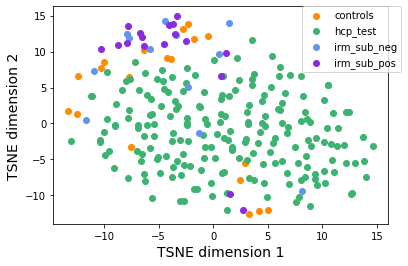

In [310]:
arr = X_embedded
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'pbs_sub_neg':'cornflowerblue','pbs_sub_pos':'blueviolet'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='pbs_sub_pos':
        g_lab= f"irm_sub_pos"
    elif g=='pbs_sub_neg':
        g_lab = 'irm_sub_neg'
    else:
        g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'TSNE dimension 1', fontsize=14)
plt.ylabel(f'TSNE dimension 2', fontsize=14)
plt.show()

### Latent space analysis - PBS data

In [311]:
X_pbs = np.array(list(deletion_controls['latent']) 
                 + list(deletion_pbs_sub_neg['latent'])
                 + list(deletion_pbs_sub_pos['latent']))
labels_pbs = np.array(['controls' for k in range(len(deletion_controls))] + 
                      ['pbs_sub_neg' for k in range(len(deletion_pbs_sub_neg))] +
                      ['pbs_sub_pos' for k in range(len(deletion_pbs_sub_pos))])
subjects = np.array(list(deletion_controls['sub']) 
                 + list(deletion_pbs_sub_neg['sub'])
                 + list(deletion_pbs_sub_pos['sub']))

In [312]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_pbs)

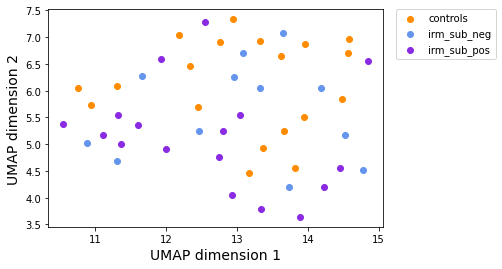

In [313]:
arr = embedding
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'pbs_sub_neg':'cornflowerblue','pbs_sub_pos':'blueviolet'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_pbs):
    ix = np.where(labels_pbs == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='pbs_sub_pos':
        g_lab= f"irm_sub_pos"
    elif g=='pbs_sub_neg':
        g_lab = 'irm_sub_neg'
    else:
        g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [314]:
X_embedded = TSNE(n_components=2, perplexity=15).fit_transform(X_pbs)

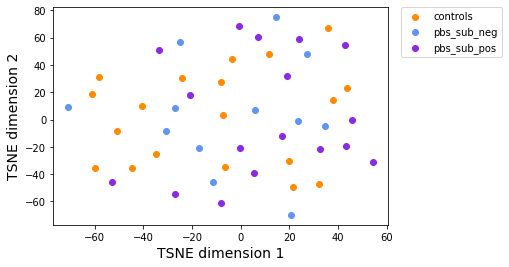

In [315]:
arr = X_embedded
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'pbs_sub_neg':'cornflowerblue','pbs_sub_pos':'blueviolet'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_pbs):
    ix = np.where(labels_pbs == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'TSNE dimension 1', fontsize=14)
plt.ylabel(f'TSNE dimension 2', fontsize=14)
plt.show()

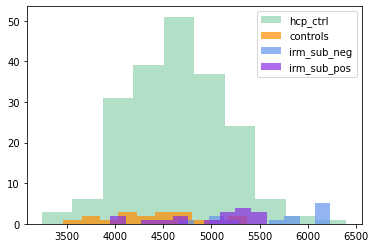

In [316]:
plt.subplot()
plt.hist(deletion_hcp.recon, color='mediumseagreen', alpha=0.4, label='hcp_ctrl',bins=10)
plt.hist(deletion_controls.recon, color='darkorange', alpha=0.7, label='controls', bins=10)
plt.hist(deletion_pbs_sub_neg.recon, color='cornflowerblue', alpha=0.7, label='irm_sub_neg', bins=10)
plt.hist(deletion_pbs_sub_pos.recon, color='blueviolet', alpha=0.7, label='irm_sub_pos', bins=10)
plt.legend()

In [481]:
F,p_hcp_ctrl = mannwhitneyu(deletion_hcp.recon, deletion_controls.recon)
print(p_hcp_ctrl)
F,p_ctrl_neg = mannwhitneyu(deletion_controls.recon, deletion_pbs_sub_neg.recon)
print(p_ctrl_neg)
F,p_ctrl_pos = mannwhitneyu(deletion_controls.recon, deletion_pbs_sub_pos.recon)
print(p_ctrl_pos)
F,p_hcp_neg = mannwhitneyu(deletion_hcp.recon, deletion_pbs_sub_neg.recon)
print(p_hcp_neg)
F,p_hcp_pos = mannwhitneyu(deletion_hcp.recon, deletion_pbs_sub_pos.recon)
print(p_hcp_pos)
F,p_neg_pos = mannwhitneyu(deletion_pbs_sub_neg.recon, deletion_pbs_sub_pos.recon)
print(p_neg_pos)

0.049667861239613476
2.2926908658903393e-05
0.001776998608502298
1.213167256059201e-06
0.002567199889274041
0.0042105306538814365


In [482]:
#from statsmodels.sandbox.stats.multicomp import multipletests
pvalues = np.array([p_hcp_ctrl, p_ctrl_neg, p_ctrl_pos, p_hcp_neg, p_hcp_pos, p_neg_pos])
multipletests(pvalues, method='bonferroni')

(array([False,  True,  True,  True,  True,  True]),
 array([2.98007167e-01, 1.37561452e-04, 1.06619917e-02, 7.27900354e-06,
        1.54031993e-02, 2.52631839e-02]),
 0.008512444610847103,
 0.008333333333333333)

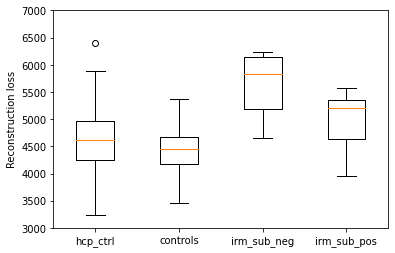

In [479]:
plt.boxplot((deletion_hcp.recon, deletion_controls.recon, deletion_pbs_sub_neg.recon, deletion_pbs_sub_pos.recon),
            labels=('hcp_ctrl','controls','irm_sub_neg', 'irm_sub_pos'))
plt.ylabel('Reconstruction loss')
plt.ylim(3000,7000)
plt.rcParams['axes.grid'] = False

### Distributions of latent dimensions

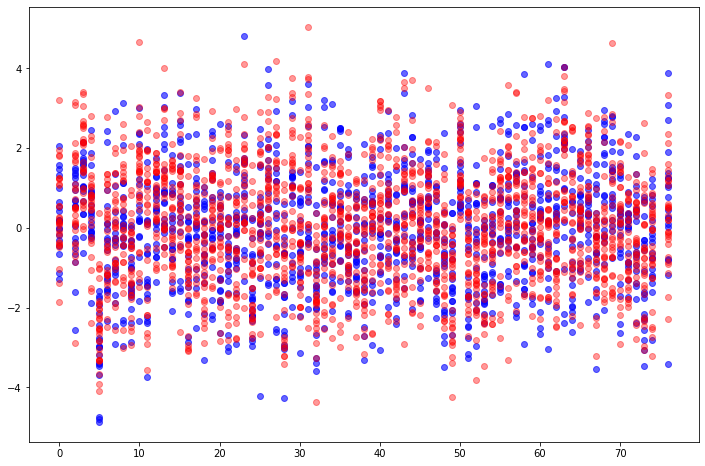

In [82]:
fig = plt.figure(figsize=(12,8))
for i in range(75):
    x = [i+i%3 for k in range(len(df_encoded_rightH[df_encoded_rightH.group=='controls']))]
    x_sub_neg = [i+i%3 for k in range(len(df_encoded_rightH[df_encoded_rightH.group=='pbs_sub_neg']))]
    x_sub_pos = [i+i%3 for k in range(len(df_encoded_rightH[df_encoded_rightH.group=='pbs_sub_pos']))]
    plt.scatter(x, [df_encoded_rightH[df_encoded_rightH.group=='controls'].latent[k][i] for k in df_encoded_rightH[df_encoded_rightH.group=='controls'].index], c='b', alpha=0.6)
    plt.scatter(x_sub_neg, [df_encoded_rightH[df_encoded_rightH.group=='pbs_sub_neg'].latent[k][i] for k in df_encoded_rightH[df_encoded_rightH.group=='pbs_sub_neg'].index], c='r', alpha=0.4)
    plt.scatter(x_sub_pos, [df_encoded_rightH[df_encoded_rightH.group=='pbs_sub_pos'].latent[k][i] for k in df_encoded_rightH[df_encoded_rightH.group=='pbs_sub_pos'].index], c='r', alpha=0.4)

## Focus on subjects with a PBS

In [92]:
pbs_list = [('pbs_sub_neg','nsujet08'), ('pbs_sub_neg','nsujet10'), ('pbs_sub_neg','nsujet12'), 
            ('pbs_sub_neg','nsujet22'),('pbs_sub_neg','snujet23'),
            ('pbs_sub_pos', 'sujet07'), ('pbs_sub_pos', 'sujet08'), ('pbs_sub_pos', 'sujet13'), 
            ('pbs_sub_pos', 'sujet36'),
            ('pbs_sub_pos', 'sujet41'), ('controls','control07')]

In [89]:
len(df_encoded_rightH)

248

In [446]:
df_encoded_rightH = df_encoded_rightH.reset_index(drop=True)
df_encoded_rightH['pbs'] = [False for k in range(len(df_encoded_rightH))]

for k in range(200, len(df_encoded_rightH)):
    for group, sub in pbs_list:
        if (df_encoded_rightH['sub'][k] == sub) & (df_encoded_rightH['group'][k] == group):
            df_encoded_rightH['pbs'][k] = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [453]:
reducer = umap.UMAP(n_neighbors=35, random_state=12)
embedding = reducer.fit_transform(X_pbs)
pbs = np.array(df_encoded_rightH.pbs[200:])

In [454]:
marker = ['x' if pbs[k] else 'o' for k in range(len(pbs))]
color = [color_dict[group] for group in labels_pbs]
x = np.array([embedding[k][0] for k in range(len(embedding))])
y = np.array([embedding[k][1] for k in range(len(embedding))])

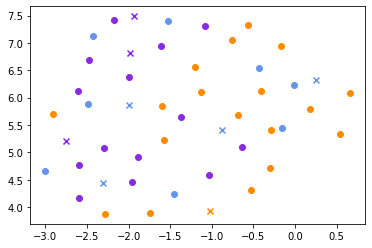

In [455]:
for m, c, _x, _y in zip(marker, color, x, y):
    plt.scatter(_x, _y, marker=m, c=c)

#### With HCP test data

In [458]:
reducer = umap.UMAP(n_neighbors=35, random_state=15)
embedding = reducer.fit_transform(X_all)
pbs = np.array(df_encoded_rightH.pbs)

In [459]:
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'pbs_sub_neg':'cornflowerblue','pbs_sub_pos':'blueviolet'}

marker = ['x' if pbs[k] else 'o' for k in range(len(pbs))]
color = []
for group in labels:
    if group=='irm_sub_neg':
        color.append('cornflowerblue')
    elif group=='irm_sub_pos':
        color.append('blueviolet')
    else:
        color.append(color_dict[group])
#color = [color_dict[group] for group in labels]
x = np.array([embedding[k][0] for k in range(len(embedding))])
y = np.array([embedding[k][1] for k in range(len(embedding))])

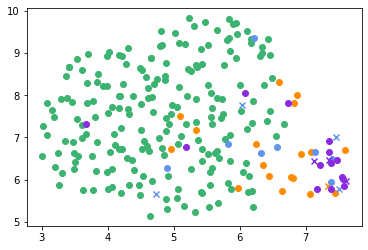

In [460]:
for m, c, _x, _y in zip(marker, color, x, y):
    plt.scatter(_x, _y, marker=m, c=c)

In [461]:
X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(X_pbs)
labels_pbs = np.array(df_encoded_rightH.pbs[200:])

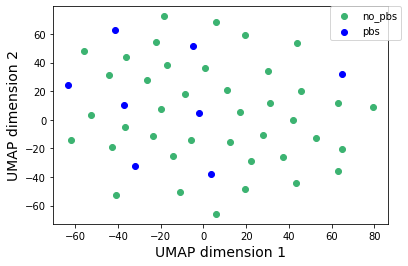

In [462]:
arr = X_embedded
color_dict = {False:'mediumseagreen', True:'blue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_pbs):
    ix = np.where(labels_pbs == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g:
        g_lab= "pbs"
    else:
        g_lab = "no_pbs"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
# for i, txt in enumerate(list(deletion_ccd_subjects['sub'])):
#         ax.annotate(txt, (embedding[207:][i][0], embedding[207:][i][1]))

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [463]:
reducer = umap.UMAP(n_neighbors=35, random_state=12)
embedding = reducer.fit_transform(X_pbs)

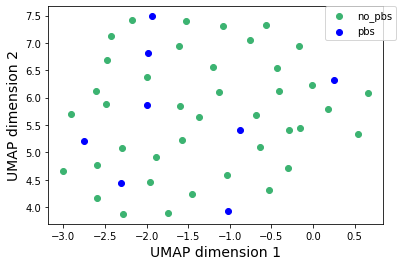

In [464]:
arr = embedding
color_dict = {False:'mediumseagreen', True:'blue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_pbs):
    ix = np.where(labels_pbs == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g:
        g_lab= "pbs"
    else:
        g_lab = "no_pbs"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
# for i, txt in enumerate(list(deletion_ccd_subjects['sub'])):
#         ax.annotate(txt, (embedding[207:][i][0], embedding[207:][i][1]))

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

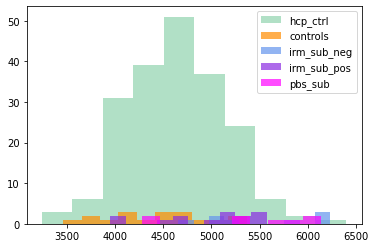

In [324]:
plt.subplot()
plt.hist(df_encoded_rightH[(df_encoded_rightH.pbs==False) & (df_encoded_rightH.group=='hcp_test')].recon, color='mediumseagreen', alpha=0.4, label='hcp_ctrl',bins=10)
plt.hist(df_encoded_rightH[(df_encoded_rightH.pbs==False) & (df_encoded_rightH.group=='controls')].recon, color='darkorange', alpha=0.7, label='controls', bins=10)
plt.hist(df_encoded_rightH[(df_encoded_rightH.pbs==False) & (df_encoded_rightH.group=='pbs_sub_neg')].recon, color='cornflowerblue', alpha=0.7, label='irm_sub_neg', bins=10)
plt.hist(df_encoded_rightH[(df_encoded_rightH.pbs==False) & (df_encoded_rightH.group=='pbs_sub_pos')].recon, color='blueviolet', alpha=0.7, label='irm_sub_pos', bins=10)
plt.hist(df_encoded_rightH[(df_encoded_rightH.pbs==True)].recon, color='magenta', alpha=0.7, label='pbs_sub', bins=10)
plt.legend()

In [160]:
hcp = df_encoded_rightH[(df_encoded_rightH.pbs==False) & (df_encoded_rightH.group=='hcp_test')].recon
controls = df_encoded_rightH[(df_encoded_rightH.pbs==False) & (df_encoded_rightH.group=='controls')].recon
pbs_neg = df_encoded_rightH[(df_encoded_rightH.pbs==False) & (df_encoded_rightH.group=='pbs_sub_neg')].recon
pbs_pos = df_encoded_rightH[(df_encoded_rightH.pbs==False) & (df_encoded_rightH.group=='pbs_sub_pos')].recon
pbs = df_encoded_rightH[(df_encoded_rightH.pbs==True)].recon

In [112]:
F,p_ctrl_pbs = mannwhitneyu(controls, pbs)
print(p_ctrl_pbs)
F,p_hcp_pbs = mannwhitneyu(hcp, pbs)
print(p_hcp_pbs)
F,p_pbs_neg_pbs = mannwhitneyu(pbs_neg, pbs)
print(p_pbs_neg_pbs)
F,p_pbs_pos_pbs = mannwhitneyu(pbs_pos, pbs)
print(p_pbs_pos_pbs)

0.004158911895430182
0.0023677330607239293
0.31825124345693306
0.06230866536177154


In [113]:
pvalues = np.array([p_hcp_ctrl, p_ctrl_neg, p_ctrl_pos, p_hcp_neg, p_hcp_pos, p_ctrl_pbs, p_hcp_pbs, 
                    p_pbs_neg_pbs, p_pbs_pos_pbs])
multipletests(pvalues, method='bonferroni')

(array([False,  True,  True,  True,  True,  True,  True, False, False]),
 array([4.47010751e-01, 2.06342178e-04, 1.59929875e-02, 1.09185053e-05,
        2.31047990e-02, 3.74302071e-02, 2.13095975e-02, 1.00000000e+00,
        5.60777988e-01]),
 0.005683044988048058,
 0.005555555555555556)

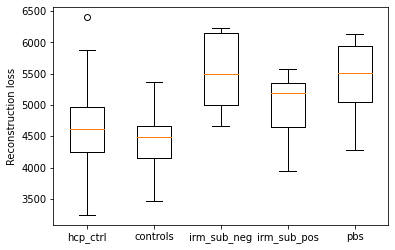

In [161]:
plt.boxplot((hcp, controls, pbs_neg, pbs_pos, pbs),
            labels=('hcp_ctrl','controls','irm_sub_neg', 'irm_sub_pos', 'pbs'))
plt.ylabel('Reconstruction loss')
#plt.ylim(1500,5500)
plt.rcParams['axes.grid'] = False

In [115]:
df_encoded[200:].sort_values(by='recon', ascending=False)

,latent,loss,recon,input,var,sub,group,handedness
235,"[-1.4757527, -0.92527175, -0.3692636, 0.475404...",7130,6813,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.083719626, 0.028610546, 0.18415575, 0.04229...",sujet05,pbs_sub_pos,G
228,"[1.2394698, 0.73551553, 0.77991873, 2.5421038,...",6550,6230,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.070729494, 0.03018069, 0.19440311, 0.039622...",nsujet20,pbs_sub_neg,D
225,"[-0.38711444, -0.7033296, 1.7791798, 2.159376,...",6517,6183,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.04868136, 0.026847346, 0.031177582, 0.17786...",nsujet13,pbs_sub_neg,D
230,"[-0.13480605, -0.42999968, 1.0937973, 3.417509...",6508,6144,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.07145638, 0.028686471, 0.034130845, 0.06251...",nsujet23,pbs_sub_neg,D
222,"[0.17533799, 0.095984094, 0.082480736, 0.96319...",6457,6141,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.07540783, 0.033652093, 0.08616431, 0.072967...",nsujet08,pbs_sub_neg,D
233,"[0.60199434, 0.3710033, -0.6587182, 2.5008311,...",6472,6138,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.08439377, 0.026593344, 0.12475267, 0.022795...",sujet03,pbs_sub_pos,G
223,"[1.2394214, -0.37019187, 0.82962143, 2.1459541...",6446,6107,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.06878812, 0.035557296, 0.027341176, 0.10705...",nsujet10,pbs_sub_neg,D
229,"[1.7924198, 0.12013081, -1.5882704, 1.4530994,...",6269,5889,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.044706956, 0.039971847, 0.06546546, 0.05137...",nsujet22,pbs_sub_neg,D
231,"[0.27831423, 0.53221357, -0.38282874, 3.362724...",6056,5768,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.052809514, 0.075477086, 0.03451232, 0.01989...",nsujet26,pbs_sub_neg,D
224,"[-0.34977633, -0.5908157, 1.323921, 0.6808693,...",6000,5683,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.049755737, 0.03140645, 0.02586854, 0.070867...",nsujet12,pbs_sub_neg,D


# Average Patterns

In [163]:
controls = df_encoded_rightH[df_encoded_rightH.group=='controls'].latent
pbs_neg = df_encoded_rightH[df_encoded_rightH.group=='pbs_sub_neg'].latent
pbs_pos = df_encoded_rightH[df_encoded_rightH.group=='pbs_sub_pos'].latent

In [117]:
enc_ctrl = np.array([np.mean([controls[k][i] for k in controls.index]) for i in range(75)])
enc_neg = np.array([np.mean([pbs_neg[k][i] for k in pbs_neg.index]) for i in range(75)])
enc_pos = np.array([np.mean([pbs_pos[k][i] for k in pbs_pos.index]) for i in range(75)])

In [118]:
tgt_dir = '/neurospin/dico/lguillon/distmap/PBS/results/'

In [125]:
z = torch.from_numpy(np.array(enc_ctrl)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.35] = 1
out[out<=0.35] = 0

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}ctrl_bucket_rightH.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}ctrl_mesh_rightH.mesh")

In [126]:
z = torch.from_numpy(np.array(enc_neg)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.35] = 1
out[out<=0.35] = 0

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}pbs_neg_bucket_rightH.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}pbs_neg_mesh_rightH.mesh")

In [127]:
z = torch.from_numpy(np.array(enc_pos)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.35] = 1
out[out<=0.35] = 0

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}pbs_pos_bucket_rightH.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}pbs_pos_mesh_rightH.mesh")

#### HCP average pattern

In [372]:
hcp = df_encoded_rightH[df_encoded_rightH.group=='hcp_test'].latent
enc_hcp = np.array([np.mean([hcp[k][i] for k in hcp.index]) for i in range(75)])

In [373]:
tgt_dir = '/neurospin/dico/lguillon/distmap/PBS/results/'

z = torch.from_numpy(np.array(enc_hcp)).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
out = np.array(np.squeeze(out).cpu().detach().numpy())

out[out>0.35] = 1
out[out<=0.35] = 0

aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), 
                                                      voxel_size=(1,1,1)), 
            f"{tgt_dir}hcp_bucket_rightH.bck")

aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
            f"{tgt_dir}hcp_mesh_rightH.mesh")

### Visualization of average patterns in the UMAP space

### Solution 1: fit on all data

In [342]:
X_all = np.array(list(deletion_hcp['latent']) + 
                 list(deletion_controls['latent']) + 
                 list(deletion_pbs_sub_neg['latent']) + 
                 list(deletion_pbs_sub_pos['latent']) +
                 [enc_ctrl] +
                 [enc_neg] + 
                 [enc_pos])
labels = np.array(['hcp_test' for k in range(200)] + 
                  ['controls' for k in range(len(deletion_controls))] + 
                  ['irm_sub_neg' for k in range(len(deletion_pbs_sub_neg))] +
                  ['irm_sub_pos' for k in range(len(deletion_pbs_sub_pos))])

In [343]:
reducer = umap.UMAP(n_neighbors=35, random_state=10)
embedding = reducer.fit_transform(X_all)

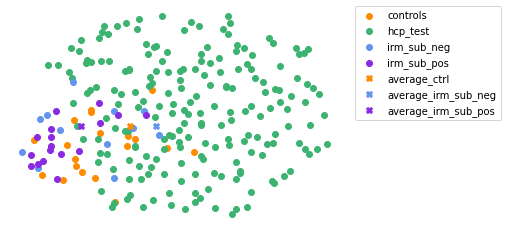

In [345]:
arr = embedding
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'irm_sub_neg':'cornflowerblue','irm_sub_pos':'blueviolet'}

fig = plt.figure(figsize=(6, 4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='pbs_sub_pos':
        g_lab= f"irm_sub_pos"
    elif g=='pbs_sub_neg':
        g_lab = 'irm_sub_neg'
    else:
        g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=1)

ax.scatter(embedding[-3][0], embedding[-3][1], c ='darkorange', 
           label = 'average_ctrl', marker='X', alpha=1)
ax.scatter(embedding[-2][0], embedding[-3][1], c ='cornflowerblue', 
           label = 'average_irm_sub_neg', marker='X', alpha=1)
ax.scatter(embedding[-1][0], embedding[-3][1], c ='blueviolet', 
           label = 'average_irm_sub_pos', marker='X', alpha=1)

    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
ax.grid(False)
plt.axis('off')
# # Hide axes ticks
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])

# for i, txt in enumerate(list(deletion_ccd_subjects['sub'])):
#         ax.annotate(txt, (embedding[207:][i][0], embedding[207:][i][1]))

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [358]:
X_all = np.array(list(deletion_hcp['latent']) + 
                 list(deletion_controls['latent']) + 
                 list(deletion_pbs_sub_neg['latent']) + 
                 list(deletion_pbs_sub_pos['latent']) +
                 [enc_ctrl] +
                 [enc_neg] + 
                 [enc_pos] +
                 list_enc)
labels = np.array(['hcp_test' for k in range(200)] + 
                  ['controls' for k in range(len(deletion_controls))] + 
                  ['irm_sub_neg' for k in range(len(deletion_pbs_sub_neg))] +
                  ['irm_sub_pos' for k in range(len(deletion_pbs_sub_pos))])

In [361]:
embedding[-6:]

array([[-1.4875982 , -1.0856969 ],
       [-0.91306925, -1.3505644 ],
       [-0.82202566, -2.0480394 ],
       [-0.3062973 , -2.089484  ],
       [-0.1862173 , -2.8731341 ],
       [ 0.30755708, -2.383576  ]], dtype=float32)

In [359]:
reducer = umap.UMAP(n_neighbors=35, random_state=10)
embedding = reducer.fit_transform(X_all)

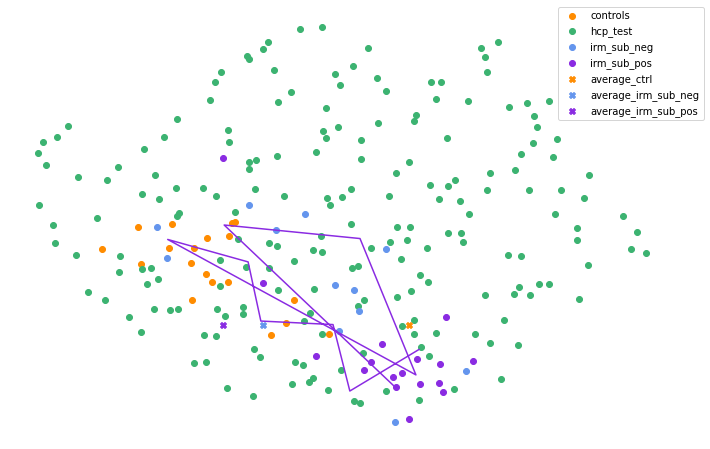

In [369]:
arr = embedding
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'irm_sub_neg':'cornflowerblue','irm_sub_pos':'blueviolet'}

fig = plt.figure(figsize=(12, 8))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='pbs_sub_pos':
        g_lab= f"irm_sub_pos"
    elif g=='pbs_sub_neg':
        g_lab = 'irm_sub_neg'
    else:
        g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=1)

ax.scatter(embedding[-13][0], embedding[-3][1], c ='darkorange', 
           label = 'average_ctrl', marker='X', alpha=1)
ax.scatter(embedding[-12][0], embedding[-3][1], c ='cornflowerblue', 
           label = 'average_irm_sub_neg', marker='X', alpha=1)
ax.scatter(embedding[-11][0], embedding[-3][1], c ='blueviolet', 
           label = 'average_irm_sub_pos', marker='X', alpha=1)

ax.plot([embedding[-10:][k][0] for k in range(10)], [embedding[-10:][k][1] for k in range(10)], c='blueviolet')

    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
ax.grid(False)
plt.axis('off')
# # Hide axes ticks
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])

# for i, txt in enumerate(list(deletion_ccd_subjects['sub'])):
#         ax.annotate(txt, (embedding[207:][i][0], embedding[207:][i][1]))

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Solution 2: fit on subjects, application on averages

In [334]:
X_all = np.array(list(deletion_hcp['latent']) + 
                 list(deletion_controls['latent']) + 
                 list(deletion_pbs_sub_neg['latent']) + 
                 list(deletion_pbs_sub_pos['latent']))

In [335]:
reducer = umap.UMAP(n_neighbors=35, random_state=15)
embedding = reducer.fit_transform(X_all)

embedding_average = reducer.transform(np.array([enc_ctrl] + [enc_neg] + [enc_pos]))

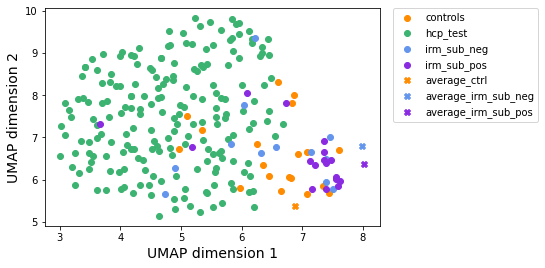

In [336]:
arr = embedding
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'irm_sub_neg':'cornflowerblue','irm_sub_pos':'blueviolet'}

fig = plt.figure(figsize=(6, 4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='pbs_sub_pos':
        g_lab= f"irm_sub_pos"
    elif g=='pbs_sub_neg':
        g_lab = 'irm_sub_neg'
    else:
        g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=1)

ax.scatter(embedding_average[0][0], embedding_average[0][1], c ='darkorange', 
           label = 'average_ctrl', marker='X', alpha=1)
ax.scatter(embedding_average[1][0], embedding_average[1][1], c ='cornflowerblue', 
           label = 'average_irm_sub_neg', marker='X', alpha=1)
ax.scatter(embedding_average[2][0], embedding_average[2][1], c ='blueviolet', 
           label = 'average_irm_sub_pos', marker='X', alpha=1)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Solution 3: fit on subject, visualization of averages computed on subjects projections 

In [331]:
X_all = np.array(list(deletion_hcp['latent']) + 
                 list(deletion_controls['latent']) + 
                 list(deletion_pbs_sub_neg['latent']) + 
                 list(deletion_pbs_sub_pos['latent']))

labels = np.array(['hcp_test' for k in range(200)] + 
                  ['controls' for k in range(len(deletion_controls))] + 
                  ['irm_sub_neg' for k in range(len(deletion_pbs_sub_neg))] +
                  ['irm_sub_pos' for k in range(len(deletion_pbs_sub_pos))])

reducer = umap.UMAP(n_neighbors=35, random_state=15)
embedding = reducer.fit_transform(X_all)

average_ctrl = np.mean(embedding[labels=='controls'], axis=0)
average_sub_neg = np.mean(embedding[labels=='irm_sub_neg'], axis=0)
average_sub_pos = np.mean(embedding[labels=='irm_sub_pos'], axis=0)

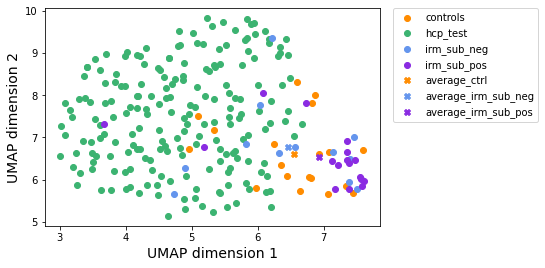

In [333]:
arr = embedding
color_dict = {'hcp_test':'mediumseagreen', 'controls': 'darkorange', 
              'irm_sub_neg':'cornflowerblue','irm_sub_pos':'blueviolet'}

fig = plt.figure(figsize=(6, 4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='pbs_sub_pos':
        g_lab= f"irm_sub_pos"
    elif g=='pbs_sub_neg':
        g_lab = 'irm_sub_neg'
    else:
        g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=1)

ax.scatter(average_ctrl[0], average_ctrl[1], c ='darkorange', 
           label = 'average_ctrl', marker='X', alpha=1)
ax.scatter(average_sub_neg[0], average_sub_neg[1], c ='cornflowerblue', 
           label = 'average_irm_sub_neg', marker='X', alpha=1)
ax.scatter(average_sub_pos[0], average_sub_pos[1], c ='blueviolet', 
           label = 'average_irm_sub_pos', marker='X', alpha=1)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

## Interpolations

In [350]:
z_ctrl = np.array(enc_ctrl)
z_pbs_pos = np.array(enc_pos)
list_enc = [z_ctrl] + [z_ctrl + ((z_pbs_pos-z_ctrl)/5)*k for k in [1,2,3,4]] + [z_pbs_pos]

In [133]:
arr_out = []
values = []

for k in range(6):
    enc = list_enc[k]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    
    out[out>0.35] = 1
    out[out<=0.35] = 0
    
    arr_out.append(out)
    values.append(f"step_{k}")

In [134]:
tgt_dir = '/neurospin/dico/lguillon/distmap/PBS/results/'
for k in range(6):
    #np.save(f"{tgt_dir}skel_step_{k}", arr_out[k])
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), 
                                                          voxel_size=(1,1,1)), 
                f"{tgt_dir}interpolation_bucket_step_{k}.bck")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(arr_out[k])), 
            f"{tgt_dir}interpolation_mesh_step_{k}.mesh")

### Interpolations beyond the average of patients

In [367]:
len(list_enc)

10

In [365]:
z_ctrl = np.array(enc_ctrl)
z_pbs_pos = np.array(enc_pos)
list_enc = [z_ctrl] + [z_ctrl + ((z_pbs_pos-z_ctrl)/5)*k for k in [1,2,3,4]] + [z_pbs_pos] + [z_ctrl + ((z_pbs_pos-z_ctrl)/5)*k for k in [6,7,8,9]]

In [303]:
arr_out = []
values = []

for k in range(10):
    enc = list_enc[k]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    
    out[out>0.38] = 1
    out[out<=0.38] = 0
    
    arr_out.append(out)
    values.append(f"step_{k}")

In [304]:
tgt_dir = '/neurospin/dico/lguillon/distmap/PBS/results/'
for k in range(10):
    #np.save(f"{tgt_dir}skel_step_{k}", arr_out[k])
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), 
                                                          voxel_size=(1,1,1)), 
                f"{tgt_dir}interpolation_bucket_step_{k}.bck")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(arr_out[k])), 
            f"{tgt_dir}interpolation_mesh_step_{k}.mesh")

In [295]:
z_ctrl = np.array(enc_ctrl)
z_pbs_neg = np.array(enc_neg)
list_enc = [z_ctrl] + [z_ctrl + ((z_pbs_neg-z_ctrl)/5)*k for k in [1,2,3,4]] + [z_pbs_neg] + [z_ctrl + ((z_pbs_neg-z_ctrl)/5)*k for k in [6,7,8,9]]

In [298]:
arr_out = []
values = []

for k in range(10):
    enc = list_enc[k]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    
    out[out>0.38] = 1
    out[out<=0.38] = 0
    
    arr_out.append(out)
    values.append(f"step_{k}")

In [299]:
tgt_dir = '/neurospin/dico/lguillon/distmap/PBS/results/'
for k in range(10):
    #np.save(f"{tgt_dir}skel_step_{k}", arr_out[k])
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), 
                                                          voxel_size=(1,1,1)), 
                f"{tgt_dir}interpolation_bucket_step_{k}_neg.bck")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(arr_out[k])), 
            f"{tgt_dir}interpolation_mesh_step_{k}_neg.mesh")

## Reconstruction

In [13]:
df_encoded_rightH.head()

,latent,loss,recon,input,sub,group
0,"[0.30990145, -1.8776301, 1.8489814, 0.3253556,...",5265,4907,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,932554,hcp_test
1,"[2.9290807, 2.2934983, 0.7623368, 1.893309, -0...",4908,4562,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,387959,hcp_test
2,"[0.28676105, 2.0780075, 1.4219029, 2.0806706, ...",5155,4812,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,887373,hcp_test
3,"[-1.0776975, -0.3607143, 2.0666773, 1.0325136,...",5631,5332,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,704238,hcp_test
4,"[-0.00579176, 1.7885638, 3.1161547, 0.34614325...",4797,4444,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,169040,hcp_test


In [137]:
tgt_dir = "/neurospin/dico/lguillon/distmap/PBS/results/reconstructions_pbs_pos/"

for k in df_encoded_rightH[df_encoded_rightH['group']=='pbs_sub_pos'].index:
    enc = df_encoded_rightH.latent[k]
    sub = df_encoded_rightH['sub'][k]
    input_pbs = np.squeeze(df_encoded_rightH['input'][k])
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())

    error = input_pbs - out
    error2 = out - input_pbs

    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    input_pbs[input_pbs>0.4] = 1
    input_pbs[input_pbs<=0.4] = 0
    out[out>0.4] = 1
    out[out<=0.4] = 0

    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error)), 
            f"{tgt_dir}{sub}_error_missing.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error2)), 
               f"{tgt_dir}{sub}_error_adding.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(input_pbs)), 
            f"{tgt_dir}{sub}_input.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
               f"{tgt_dir}{sub}_out.mesh")

231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247


In [140]:
tgt_dir = "/neurospin/dico/lguillon/distmap/PBS/results/reconstructions_pbs_neg/"

for k in df_encoded_rightH[df_encoded_rightH['group']=='pbs_sub_neg'].index:
    enc = df_encoded_rightH.latent[k]
    sub = df_encoded_rightH['sub'][k]
    input_pbs = np.squeeze(df_encoded_rightH['input'][k])
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())

    error = input_pbs - out
    error2 = out - input_pbs

    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    input_pbs[input_pbs>0.4] = 1
    input_pbs[input_pbs<=0.4] = 0
    out[out>0.4] = 1
    out[out<=0.4] = 0

    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error)), 
            f"{tgt_dir}{sub}_error_missing.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error2)), 
               f"{tgt_dir}{sub}_error_adding.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(input_pbs)), 
            f"{tgt_dir}{sub}_input.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
               f"{tgt_dir}{sub}_out.mesh")

In [155]:
len(input_data['ccd_subjects'])

7

In [161]:
tgt_dir = "/neurospin/dico/lguillon/distmap/CCD/results/"

for k in range(len(deletion_ccd_subjects)):
    enc = deletion_ccd_subjects.latent[k]
    input_ccd = np.squeeze(input_data['ccd_subjects'][k])
    sub = deletion_ccd_subjects['sub'][k]
    
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    
    error = input_ccd - out
    error2 = out - input_ccd

    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error)), 
            f"{tgt_dir}{sub}_error_missing.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error2)), 
               f"{tgt_dir}{sub}_error_adding.mesh")

### Reconstruction of controls

In [22]:
tgt_dir = "/neurospin/dico/lguillon/distmap/CCD/results/"

for k in range(3):
    enc = deletion_controls.latent[k]
    input_ctrl = np.squeeze(input_data['controls'][k])
    sub = deletion_controls['sub'][k]
    
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    
    error = input_ctrl - out
    error2 = out - input_ctrl

    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    
    out[out>0.4] = 1
    out[out<=0.4] = 0
    input_ctrl[input_ctrl>0.4] = 1
    input_ctrl[input_ctrl<=0.4] = 0
    
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error)), 
            f"{tgt_dir}{sub}_error_missing.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(error2)), 
               f"{tgt_dir}{sub}_error_adding.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(input_ctrl)), 
            f"{tgt_dir}{sub}_input.mesh")
    aims.write(dtx.convert.bucket_to_mesh(dtx.convert.volume_to_bucket_numpy(out)), 
               f"{tgt_dir}{sub}_recon.mesh")